In [3]:
import nltk
nltk.download('wordnet', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)


True

In [6]:
# Cell 1: Original augmented learning code (muting all nltk.download outputs)

import nltk
# First download normally (run only once, quiet=True silent mode)
nltk.download('wordnet', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)
# Then rewrite download function to empty, blocking any subsequent download prints
nltk.download = lambda *args, **kwargs: True

from transformers import AlbertTokenizer, AlbertForSequenceClassification, TrainingArguments, Trainer
import torch
import torch.nn as nn
import pandas as pd
import nlpaug.augmenter.word as naw
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# -------- Synonym Augmenter --------
aug = naw.SynonymAug(aug_src='wordnet')
def augment_text(text):
    try:
        return aug.augment(text)
    except:
        return text

# -------- Custom Dataset Class --------
class TextDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, tokenizer, max_length=128):
        self.tokenizer = tokenizer
        self.texts     = dataframe['Text'].tolist()
        self.labels    = dataframe['Label'].tolist()
        self.max_length= max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            padding='max_length',
            truncation=True,
            max_length=self.max_length,
            return_tensors='pt'
        )
        item = {key: val.squeeze(0) for key,val in encoding.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item


# -------- Load and Augment Data --------
def load_and_augment(path):
    df = pd.read_csv(path, sep='\t')
    if df.columns[0] != 'Id':
        df.columns = ['Id', 'Text', 'Label']
    df['Label'] = df['Label'].map({'INFORMATIVE': 1, 'UNINFORMATIVE': 0})
    print(f"✅ Original data size: {len(df)}")

    aug_df = df.copy()
    aug_df['Text'] = aug_df['Text'].apply(augment_text)
    full_df = pd.concat([df, aug_df]).sample(frac=1).reset_index(drop=True)
    print(f"✅ Augmented data size: {len(full_df)}")
    return full_df

# -------- Evaluation Metrics --------
def compute_metrics(pred):
    labels = pred.label_ids
    preds  = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': round(acc, 4),
        'f1':       round(f1, 4),
        'precision':round(precision, 4),
        'recall':   round(recall, 4)
    }

# -------- Custom Trainer (with weighted loss) --------
class WeightedLossTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits  = outputs.logits
        weight  = torch.tensor([0.7, 1.7]).to(logits.device)
        loss_fct= nn.CrossEntropyLoss(weight=weight)
        loss    = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss

# -------- Model and Tokenizer --------
tokenizer = AlbertTokenizer.from_pretrained('albert-base-v2')
model     = AlbertForSequenceClassification.from_pretrained('albert-base-v2', num_labels=2)

# -------- Data Loading --------
train_df = load_and_augment('./WNUT-2020-Task-2-Dataset/train.tsv')
valid_df = pd.read_csv('./WNUT-2020-Task-2-Dataset/valid.tsv', sep='\t')
valid_df.columns = ['Id', 'Text', 'Label']
valid_df['Label'] = valid_df['Label'].map({'INFORMATIVE': 1, 'UNINFORMATIVE': 0})
train_ds = TextDataset(train_df, tokenizer)
valid_ds = TextDataset(valid_df, tokenizer)

# -------- Training Arguments --------
training_args = TrainingArguments(
    output_dir='./results',
    per_device_train_batch_size=32,
    per_device_eval_batch_size=128,
    num_train_epochs=6,
    learning_rate=3e-5,
    weight_decay=0.1,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    save_total_limit=2,
    logging_dir='./logs',
    logging_steps=100,
    warmup_steps=500,
)

# -------- Trainer & Training --------
print(f"Model parameter count: {sum(p.numel() for p in model.parameters())}")
trainer = WeightedLossTrainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=valid_ds,
    compute_metrics=compute_metrics
)
trainer.train()
model.save_pretrained('./results/')
tokenizer.save_pretrained('./results/')
print("✅ Model training completed and saved to ./results/")

Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertForSequenceClassification: ['predictions.bias', 'predictions.dense.bias', 'predictions.decoder.bias', 'predictions.decoder.weight', 'predictions.dense.weight', 'predictions.LayerNorm.bias', 'predictions.LayerNorm.weight']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You sho

✅ 原始数据量: 6936
✅ 增强后数据量: 13872
模型参数量: 11685122


/opt/miniconda3/envs/opence-v1.5.1/lib/python3.9/site-packages/torch/utils/tensorboard/__init__.py:6: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, '__version__') or LooseVersion(tensorboard.__version__) < LooseVersion('1.15'):
/opt/miniconda3/envs/opence-v1.5.1/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 13872
  Num Epochs = 6
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 1302
/opt/miniconda3/envs/opence-v1.5.1/lib/python3.9/site-packages/torch/cuda/nccl.py:51: DeprecationWarning: Using 

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.202900,0.286843,0.883900,0.884000,0.837100,0.936400
2,0.125400,0.372762,0.877900,0.872100,0.863100,0.881400
3,0.084700,0.604765,0.878900,0.870000,0.882400,0.858100
4,0.042600,0.675797,0.896900,0.887900,0.912800,0.864400
5,0.011800,0.737080,0.881900,0.872000,0.893300,0.851700
6,0.002400,0.709217,0.885900,0.878500,0.884100,0.872900


***** Running Evaluation *****
  Num examples = 999
  Batch size = 256
Saving model checkpoint to ./results/checkpoint-217
Configuration saved in ./results/checkpoint-217/config.json
Model weights saved in ./results/checkpoint-217/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 999
  Batch size = 256
Saving model checkpoint to ./results/checkpoint-434
Configuration saved in ./results/checkpoint-434/config.json
Model weights saved in ./results/checkpoint-434/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 999
  Batch size = 256
Saving model checkpoint to ./results/checkpoint-651
Configuration saved in ./results/checkpoint-651/config.json
Model weights saved in ./results/checkpoint-651/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-434] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 999
  Batch size = 256
Saving model checkpoint to ./results/checkpoint-868
Configuration saved in ./results/checkpoint-868/co

✅ 模型训练完成并已保存到 ./results/


In [8]:
from sklearn.metrics import accuracy_score, classification_report

def evaluate_on_test(model_path='./results/', test_path='WNUT-2020-Task-2-Dataset/test.tsv'):
    # Load model and tokenizer
    model = AlbertForSequenceClassification.from_pretrained(model_path)
    tokenizer = AlbertTokenizer.from_pretrained(model_path)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    # Load test data
    df = pd.read_csv(test_path, sep='\t', header=None)
    df.columns = ['Id', 'Text', 'Label']
    df['Label'] = df['Label'].map({'UNINFORMATIVE': 0, 'INFORMATIVE': 1})

    y_true = []
    y_pred = []

    model.eval()
    with torch.no_grad():
        for _, row in df.iterrows():
            text = row['Text']
            label = row['Label']
            inputs = tokenizer(
                text,
                return_tensors='pt',
                truncation=True,
                padding='max_length',
                max_length=128
            ).to(device)
            outputs = model(**inputs)
            pred = torch.argmax(outputs.logits, dim=1).item()
            y_pred.append(pred)
            y_true.append(label)

    # Print results
    acc = accuracy_score(y_true, y_pred)
    report = classification_report(y_true, y_pred, target_names=['UNINFORMATIVE', 'INFORMATIVE'], digits=4)

    print(f"\n✅ Accuracy on test set: {acc:.5f}")
    print("📊 Classification Report:\n")
    print(report)

# Run the evaluation
evaluate_on_test()

loading configuration file ./results/config.json
Model config AlbertConfig {
  "_name_or_path": "albert-base-v2",
  "architectures": [
    "AlbertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0,
  "bos_token_id": 2,
  "classifier_dropout_prob": 0.1,
  "down_scale_factor": 1,
  "embedding_size": 128,
  "eos_token_id": 3,
  "gap_size": 0,
  "hidden_act": "gelu_new",
  "hidden_dropout_prob": 0,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "inner_group_num": 1,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "albert",
  "net_structure_type": 0,
  "num_attention_heads": 12,
  "num_hidden_groups": 1,
  "num_hidden_layers": 12,
  "num_memory_blocks": 0,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.16.2",
  "type_vocab_size": 2,
  "vocab_size": 30000
}

loading weights file ./results/pytorch_model.bin
All model checkpoint weights were u


✅ Accuracy on test set: 0.88900
📊 Classification Report:

               precision    recall  f1-score   support

UNINFORMATIVE     0.8690    0.9299    0.8984      1056
  INFORMATIVE     0.9149    0.8432    0.8776       944

     accuracy                         0.8890      2000
    macro avg     0.8920    0.8866    0.8880      2000
 weighted avg     0.8907    0.8890    0.8886      2000



Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertForSequenceClassification: ['predictions.LayerNorm.weight', 'predictions.dense.bias', 'predictions.decoder.weight', 'predictions.bias', 'predictions.dense.weight', 'predictions.LayerNorm.bias', 'predictions.decoder.bias']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You sho

✅ 原始数据量: 6936
✅ 增强后数据量: 13872


Generating pseudo-labels: 100%|██████████| 375/375 [00:40<00:00,  9.18it/s]


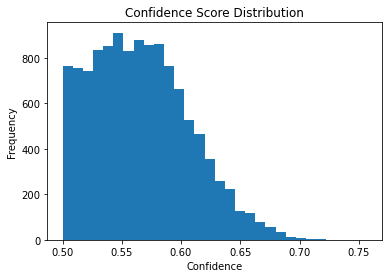

生成 17 条高置信度伪标签（阈值 0.7）


/opt/miniconda3/envs/opence-v1.5.1/lib/python3.9/site-packages/torch/utils/tensorboard/__init__.py:6: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, '__version__') or LooseVersion(tensorboard.__version__) < LooseVersion('1.15'):
/opt/miniconda3/envs/opence-v1.5.1/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 13889
  Num Epochs = 3
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 1305



Phase 3: Training with pseudo-labeled data...


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.184300,0.410443,0.869900,0.852900,0.915000,0.798700


***** Running Evaluation *****
  Num examples = 999
  Batch size = 128
Saving model checkpoint to ./results/checkpoint-435
Configuration saved in ./results/checkpoint-435/config.json
Model weights saved in ./results/checkpoint-435/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-3105] due to args.save_total_limit


In [ ]:
import nltk
# Hijack download function, block any nltk.download logs
nltk.download = lambda *args, **kwargs: True

from transformers import AlbertTokenizer, AlbertForSequenceClassification, TrainingArguments, Trainer
import torch
import torch.nn as nn
import pandas as pd
import nlpaug.augmenter.word as naw
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import numpy as np
import torch.nn.functional as F
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt  # For plotting

# ----- Redefine training_args (consistent with Cell 1) -----
training_args = TrainingArguments(
    output_dir='./results',
    per_device_train_batch_size=32,
    per_device_eval_batch_size=128,
    num_train_epochs=6,
    learning_rate=3e-5,
    weight_decay=0.1,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    save_total_limit=2,
    logging_dir='./logs',
    logging_steps=100,
    warmup_steps=500,
)

# -------- Synonym Augmenter --------
aug = naw.SynonymAug(aug_src='wordnet')
def augment_text(text):
    try:
        return aug.augment(text)
    except:
        return text

# -------- Custom Dataset Class --------
class TextDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, tokenizer, max_length=128):
        self.tokenizer = tokenizer
        self.texts     = dataframe['Text'].tolist()
        self.labels    = dataframe['Label'].tolist()
        self.max_length= max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            padding='max_length',
            truncation=True,
            max_length=self.max_length,
            return_tensors='pt'
        )
        item = {key: val.squeeze(0) for key,val in encoding.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

# -------- Load and Augment Data --------
def load_and_augment(path):
    df = pd.read_csv(path, sep='\t')
    if df.columns[0] != 'Id':
        df.columns = ['Id', 'Text', 'Label']
    df['Label'] = df['Label'].map({'INFORMATIVE': 1, 'UNINFORMATIVE': 0})
    print(f"✅ Original data size: {len(df)}")

    aug_df = df.copy()
    aug_df['Text'] = aug_df['Text'].apply(augment_text)
    full_df = pd.concat([df, aug_df]).sample(frac=1).reset_index(drop=True)
    print(f"✅ Augmented data size: {len(full_df)}")
    return full_df

# -------- Evaluation Metrics --------
def compute_metrics(pred):
    labels = pred.label_ids
    preds  = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': round(acc, 4),
        'f1':       round(f1, 4),
        'precision':round(precision, 4),
        'recall':   round(recall, 4)
    }

# -------- Custom Trainer (with weighted loss) --------
class WeightedLossTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits  = outputs.logits
        weight  = torch.tensor([0.7, 1.7]).to(logits.device)
        loss_fct= nn.CrossEntropyLoss(weight=weight)
        loss    = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss

# -------- Model and Tokenizer --------
tokenizer = AlbertTokenizer.from_pretrained('albert-base-v2')
model     = AlbertForSequenceClassification.from_pretrained('albert-base-v2', num_labels=2)

# -------- Data Loading --------
train_df = load_and_augment('./WNUT-2020-Task-2-Dataset/train.tsv')
valid_df = pd.read_csv('./WNUT-2020-Task-2-Dataset/valid.tsv', sep='\t')
valid_df.columns = ['Id', 'Text', 'Label']
valid_df['Label'] = valid_df['Label'].map({'INFORMATIVE': 1, 'UNINFORMATIVE': 0})
train_ds = TextDataset(train_df, tokenizer)
valid_ds = TextDataset(valid_df, tokenizer)

# -------- Load Unlabeled Data --------
unlabeled_df = pd.read_csv(
    './WNUT-2020-Task-2-Dataset/unlabeled_test_with_noise.tsv',
    sep='\t', names=['Id','Text'], header=0
)
unlabeled_df['Label'] = 0
unlabeled_ds = TextDataset(unlabeled_df, tokenizer, max_length=128)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def generate_pseudo_labels_with_plot(model, dataset, device,
                                     batch_size=32, threshold=0.7):
    model.to(device).eval()
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    confidences, preds = [], []

    with torch.no_grad():
        for batch in tqdm(loader, desc="Generating pseudo-labels"):
            inputs = {k: v.to(device) for k, v in batch.items() if k!='labels'}
            logits = model(**inputs).logits
            probs = F.softmax(logits, dim=-1)
            conf, pr = torch.max(probs, dim=-1)
            confidences.extend(conf.cpu().tolist())
            preds.extend(pr.cpu().tolist())

    # Visualize confidence distribution
    plt.figure()
    plt.hist(confidences, bins=30)
    plt.title('Confidence Score Distribution')
    plt.xlabel('Confidence')
    plt.ylabel('Frequency')
    plt.show()

    # Filter high-confidence pseudo labels
    indices = [i for i, c in enumerate(confidences) if c >= threshold]
    print(f"Generated {len(indices)} high-confidence pseudo labels (threshold {threshold})")
    return indices, [preds[i] for i in indices]

# Phase 2: Generate and plot confidence distribution
sel_idx, pseudo_lbls = generate_pseudo_labels_with_plot(model, unlabeled_ds, device, threshold=0.7)

if sel_idx:
    pseudo_df = unlabeled_df.iloc[sel_idx].copy()
    pseudo_df['Label'] = pseudo_lbls
    combined_df = pd.concat([train_df, pseudo_df], ignore_index=True)
    combined_ds = TextDataset(combined_df, tokenizer, max_length=128)

    # Adjust learning rate and epochs
    training_args.num_train_epochs = 3
    training_args.learning_rate    = 1e-5

    pseudo_trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=combined_ds,
        eval_dataset=valid_ds,
        compute_metrics=compute_metrics
    )
    print("\nPhase 3: Training with pseudo-labeled data...")
    pseudo_trainer.train()
    print("\nFinal evaluation:", pseudo_trainer.evaluate())

    model.save_pretrained('./final_model/')
    tokenizer.save_pretrained('./final_model/')
    print("✅ Self-supervised learning completed and saved to ./final_model/")
else:
    print("No high-confidence pseudo labels generated, skipping Phase 3")

In [1]:
from transformers import AlbertTokenizer, AlbertForSequenceClassification, TrainingArguments, Trainer
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

class TextDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, tokenizer, max_length=128):
        self.tokenizer = tokenizer
        self.texts = dataframe['Text'].tolist()
        self.labels = dataframe['Label'].tolist()
        self.max_length = max_length
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            padding='max_length',
            truncation=True,
            max_length=self.max_length,
            return_tensors='pt'
        )
        item = {key: val.squeeze(0) for key, val in encoding.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

# Load data
def load_data(path):
    df = pd.read_csv(path, sep='\t')
    if df.columns[0] != 'Id':
        df.columns = ['Id', 'Text', 'Label']
    print(f"Loaded columns: {df.columns}")
    df['Label'] = df['Label'].map({'INFORMATIVE': 1, 'UNINFORMATIVE': 0})
    return df

# Evaluation function
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# Load tokenizer and model
tokenizer = AlbertTokenizer.from_pretrained('albert-base-v2')
model = AlbertForSequenceClassification.from_pretrained('albert-base-v2', num_labels=2)

# Load datasets
train_df = load_data('./WNUT-2020-Task-2-Dataset/train.tsv')
valid_df = load_data('./WNUT-2020-Task-2-Dataset/valid.tsv')
train_ds = TextDataset(train_df, tokenizer)
valid_ds = TextDataset(valid_df, tokenizer)

# Training arguments - Add regularization and early stopping
training_args = TrainingArguments(
    output_dir='./results',
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    num_train_epochs=6,           # Reduce number of epochs
    weight_decay=0.01,            # Add weight decay
    learning_rate=2e-5,           # Set a smaller learning rate
    save_total_limit=2,
    logging_dir='./logs',
    logging_steps=100,
    evaluation_strategy="epoch",   # Evaluate once per epoch
    save_strategy="epoch",         # Save once per epoch
    load_best_model_at_end=True,   # Load the best model
    metric_for_best_model="f1",    # Use F1 as the metric for selecting the best model
    warmup_steps=500,              # Warmup steps
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=valid_ds,
    compute_metrics=compute_metrics,  # Add evaluation metrics
)

# Training
trainer.train()

# Save model
model.save_pretrained('./results/')
tokenizer.save_pretrained('./results/')

Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertForSequenceClassification: ['predictions.decoder.weight', 'predictions.dense.bias', 'predictions.decoder.bias', 'predictions.LayerNorm.weight', 'predictions.bias', 'predictions.LayerNorm.bias', 'predictions.dense.weight']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You sho

Loaded columns: Index(['Id', 'Text', 'Label'], dtype='object')
Loaded columns: Index(['Id', 'Text', 'Label'], dtype='object')


/opt/miniconda3/envs/opence-v1.5.1/lib/python3.9/site-packages/torch/utils/tensorboard/__init__.py:6: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, '__version__') or LooseVersion(tensorboard.__version__) < LooseVersion('1.15'):
/opt/miniconda3/envs/opence-v1.5.1/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 6936
  Num Epochs = 6
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 1302
/opt/miniconda3/envs/opence-v1.5.1/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: W

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.361900,0.348907,0.864865,0.861822,0.833663,0.891949
2,0.202200,0.313908,0.874875,0.864572,0.884701,0.845339
3,0.148900,0.357498,0.890891,0.887975,0.862275,0.915254
4,0.093500,0.545838,0.889890,0.887295,0.859127,0.917373
5,0.035800,0.571410,0.891892,0.887265,0.874486,0.900424
6,0.017800,0.613479,0.888889,0.885212,0.864646,0.906780


***** Running Evaluation *****
  Num examples = 999
  Batch size = 128
Saving model checkpoint to ./results/checkpoint-217
Configuration saved in ./results/checkpoint-217/config.json
Model weights saved in ./results/checkpoint-217/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-651] due to args.save_total_limit
/opt/miniconda3/envs/opence-v1.5.1/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 999
  Batch size = 128
Saving model checkpoint to ./results/checkpoint-434
Configuration saved in ./results/checkpoint-434/config.json
Model weights saved in ./results/checkpoint-434/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-285] due to args.save_total_limit
/opt/miniconda3/envs/opence-v1.5.1/lib/python

('./results/tokenizer_config.json',
 './results/special_tokens_map.json',
 './results/spiece.model',
 './results/added_tokens.json')

Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertForSequenceClassification: ['predictions.decoder.bias', 'predictions.LayerNorm.bias', 'predictions.LayerNorm.weight', 'predictions.dense.bias', 'predictions.decoder.weight', 'predictions.dense.weight', 'predictions.bias']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You sho

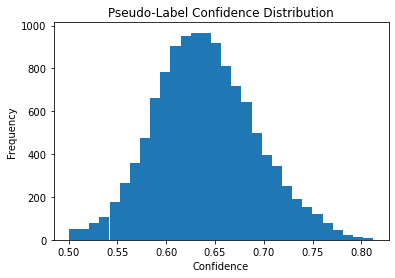

/opt/miniconda3/envs/opence-v1.5.1/lib/python3.9/site-packages/torch/utils/tensorboard/__init__.py:6: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, '__version__') or LooseVersion(tensorboard.__version__) < LooseVersion('1.15'):
/opt/miniconda3/envs/opence-v1.5.1/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 25870
  Num Epochs = 6
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 4854



▶ Phase 3: Training on augmented supervised + pseudo data …


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.437600,0.743279,0.778800,0.718500,0.901000,0.597500
2,0.302200,1.009234,0.746700,0.649100,0.939800,0.495800
3,0.155100,1.834762,0.726700,0.604900,0.954300,0.442800
4,0.093200,2.190710,0.747700,0.665800,0.890100,0.531800
5,0.026300,2.876311,0.750800,0.664900,0.911400,0.523300
6,0.005200,2.999413,0.750800,0.666700,0.905500,0.527500


***** Running Evaluation *****
  Num examples = 999
  Batch size = 128
Saving model checkpoint to ./results/checkpoint-809
Configuration saved in ./results/checkpoint-809/config.json
Model weights saved in ./results/checkpoint-809/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-870] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 999
  Batch size = 128
Saving model checkpoint to ./results/checkpoint-1618
Configuration saved in ./results/checkpoint-1618/config.json
Model weights saved in ./results/checkpoint-1618/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-1305] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 999
  Batch size = 128
Saving model checkpoint to ./results/checkpoint-2427
Configuration saved in ./results/checkpoint-2427/config.json
Model weights saved in ./results/checkpoint-2427/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-1618] due to args.save_total_limit
*****

Configuration saved in ./final_model/config.json
Model weights saved in ./final_model/pytorch_model.bin
tokenizer config file saved in ./final_model/tokenizer_config.json
Special tokens file saved in ./final_model/special_tokens_map.json



▶ Final evaluation: {'eval_loss': 0.7432789206504822, 'eval_accuracy': 0.7788, 'eval_f1': 0.7185, 'eval_precision': 0.901, 'eval_recall': 0.5975, 'eval_runtime': 3.215, 'eval_samples_per_second': 310.732, 'eval_steps_per_second': 2.488, 'epoch': 6.0}


('./final_model/tokenizer_config.json',
 './final_model/special_tokens_map.json',
 './final_model/spiece.model',
 './final_model/added_tokens.json')

In [ ]:
# Cell 2: Self-Training with Top 50% Pseudo-Labels + Augmentation

import os
# Limit threads to avoid threading/memory errors
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"

import nltk
# Block any nltk.download logs
nltk.download = lambda *args, **kwargs: True

from transformers import AlbertTokenizer, AlbertForSequenceClassification, TrainingArguments, Trainer
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import nlpaug.augmenter.word as naw
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import numpy as np
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt

# Redefine training_args (consistent with Cell 1)
training_args = TrainingArguments(
    output_dir='./results',
    per_device_train_batch_size=32,
    per_device_eval_batch_size=128,
    num_train_epochs=6,
    learning_rate=3e-5,
    weight_decay=0.1,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    save_total_limit=2,
    logging_dir='./logs',
    logging_steps=100,
    warmup_steps=500,
)
# -------- Evaluation Metrics --------
def compute_metrics(pred):
    labels = pred.label_ids
    preds  = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': round(acc, 4),
        'f1':       round(f1, 4),
        'precision':round(precision, 4),
        'recall':   round(recall, 4)
    }
# Synonym augmenter
aug = naw.SynonymAug(aug_src='wordnet')
def augment_text(text):
    try:
        return aug.augment(text)
    except:
        return text

# Basic Dataset
class TextDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, tokenizer, max_length=128):
        self.tokenizer = tokenizer
        self.texts     = dataframe['Text'].tolist()
        self.labels    = dataframe['Label'].tolist()
        self.max_length= max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            padding='max_length',
            truncation=True,
            max_length=self.max_length,
            return_tensors='pt'
        )
        item = {k: v.squeeze(0) for k, v in encoding.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

# Load & augment labeled data
def load_and_augment(path):
    df = pd.read_csv(path, sep='\t', header=0)
    if df.columns[0] != 'Id':
        df.columns = ['Id','Text','Label']
    df['Label'] = df['Label'].map({'INFORMATIVE':1,'UNINFORMATIVE':0})
    aug_df = df.copy()
    aug_df['Text'] = aug_df['Text'].apply(augment_text)
    return pd.concat([df, aug_df]).sample(frac=1).reset_index(drop=True)

train_df = load_and_augment('./WNUT-2020-Task-2-Dataset/train.tsv')
valid_df = pd.read_csv(
    './WNUT-2020-Task-2-Dataset/valid.tsv', 
    sep='\t', header=0, names=['Id','Text','Label']
)
valid_df['Label'] = valid_df['Label'].map({'INFORMATIVE':1,'UNINFORMATIVE':0})

# Load unlabeled data
unlab_df = pd.read_csv(
    './WNUT-2020-Task-2-Dataset/unlabeled_test_with_noise.tsv',
    sep='\t', header=0, names=['Id','Text']
)
unlab_df['Label'] = 0  # Placeholder

# Initialize model & tokenizer
tokenizer = AlbertTokenizer.from_pretrained('albert-base-v2')
model     = AlbertForSequenceClassification.from_pretrained('albert-base-v2', num_labels=2)
device    = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Generate pseudo labels & collect confidence
model.to(device).eval()
loader = DataLoader(TextDataset(unlab_df, tokenizer), batch_size=32, shuffle=False)
confs, preds = [], []
with torch.no_grad():
    for batch in tqdm(loader, desc="Gen pseudo"):
        inp = {k: v.to(device) for k, v in batch.items() if k!='labels'}
        logits = model(**inp).logits
        prob   = F.softmax(logits, dim=-1)
        c, p   = torch.max(prob, dim=1)
        confs.extend(c.cpu().tolist())
        preds.extend(p.cpu().tolist())

# Fill results back to DataFrame
unlab_df['Confidence'] = confs
unlab_df['Pred']       = preds

# Visualize overall confidence distribution
plt.hist(confs, bins=30)
plt.title('Pseudo-Label Confidence Distribution')
plt.xlabel('Confidence')
plt.ylabel('Frequency')
plt.show()

# Select Top 50% pseudo labels
k       = len(unlab_df) // 2
top_df  = unlab_df.nlargest(k, 'Confidence').copy()
top_df['Label'] = top_df['Pred']

# Augment Top 50% pseudo labels
aug_pseudo = top_df.copy()
aug_pseudo['Text'] = aug_pseudo['Text'].apply(augment_text)

# Merge pseudo labels before and after augmentation
pseudo_combined = pd.concat([
    top_df[['Text','Label']], 
    aug_pseudo[['Text','Label']]
]).reset_index(drop=True)

# Build final training set
final_df = pd.concat([
    train_df[['Text','Label']],  # Original labels + augmentation
    pseudo_combined             # Pseudo labels + augmentation
]).reset_index(drop=True)

final_ds = TextDataset(final_df, tokenizer)

# Final weighted training (using WeightedLossTrainer)
class WeightedLossTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels  = inputs.pop("labels")
        outputs = model(**inputs)
        logits  = outputs.logits
        weight  = torch.tensor([0.7,1.7]).to(device)
        loss_fn = nn.CrossEntropyLoss(weight=weight)
        loss    = loss_fn(logits, labels)
        return (loss, outputs) if return_outputs else loss

trainer_final = WeightedLossTrainer(
    model=model,
    args=training_args,
    train_dataset=final_ds,
    eval_dataset=TextDataset(valid_df, tokenizer),
    compute_metrics=compute_metrics
)

print("\n▶ Phase 3: Training on augmented supervised + pseudo data …")
trainer_final.train()
print("\n▶ Final evaluation:", trainer_final.evaluate())

# Save model
model.save_pretrained('./final_model/')
tokenizer.save_pretrained('./final_model/')

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

def evaluate_on_test(model_path='./final_model/', test_path='WNUT-2020-Task-2-Dataset/test.tsv'):
    # Load model and tokenizer
    model = AlbertForSequenceClassification.from_pretrained(model_path)
    tokenizer = AlbertTokenizer.from_pretrained(model_path)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    # Load test data
    df = pd.read_csv(test_path, sep='\t', header=None)
    df.columns = ['Id', 'Text', 'Label']
    df['Label'] = df['Label'].map({'UNINFORMATIVE': 0, 'INFORMATIVE': 1})

    y_true = []
    y_pred = []

    model.eval()
    with torch.no_grad():
        for _, row in df.iterrows():
            text = row['Text']
            label = row['Label']
            inputs = tokenizer(
                text,
                return_tensors='pt',
                truncation=True,
                padding='max_length',
                max_length=128
            ).to(device)
            outputs = model(**inputs)
            pred = torch.argmax(outputs.logits, dim=1).item()
            y_pred.append(pred)
            y_true.append(label)

    # Print results
    acc = accuracy_score(y_true, y_pred)
    report = classification_report(y_true, y_pred, target_names=['UNINFORMATIVE', 'INFORMATIVE'], digits=4)

    print(f"\n✅ Accuracy on test set: {acc:.5f}")
    print("📊 Classification Report:\n")
    print(report)

# Run the evaluation
evaluate_on_test()

loading configuration file ./final_model/config.json
Model config AlbertConfig {
  "_name_or_path": "albert-base-v2",
  "architectures": [
    "AlbertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0,
  "bos_token_id": 2,
  "classifier_dropout_prob": 0.1,
  "down_scale_factor": 1,
  "embedding_size": 128,
  "eos_token_id": 3,
  "gap_size": 0,
  "hidden_act": "gelu_new",
  "hidden_dropout_prob": 0,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "inner_group_num": 1,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "albert",
  "net_structure_type": 0,
  "num_attention_heads": 12,
  "num_hidden_groups": 1,
  "num_hidden_layers": 12,
  "num_memory_blocks": 0,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.16.2",
  "type_vocab_size": 2,
  "vocab_size": 30000
}

loading weights file ./final_model/pytorch_model.bin
All model checkpoint weight


✅ Accuracy on test set: 0.73250
📊 Classification Report:

               precision    recall  f1-score   support

UNINFORMATIVE     0.6731    0.9593    0.7911      1056
  INFORMATIVE     0.9131    0.4788    0.6282       944

     accuracy                         0.7325      2000
    macro avg     0.7931    0.7190    0.7097      2000
 weighted avg     0.7864    0.7325    0.7142      2000

